In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yongjoonk/bird-detection
!unzip bird-detection.zip -d bird_detection


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/yongjoonk/bird-detection
License(s): unknown
  0% 0.00/3.59M [00:00<?, ?B/s]
100% 3.59M/3.59M [00:00<00:00, 759MB/s]
Archive:  bird-detection.zip
  inflating: bird_detection/bird detection.v5i.tensorflow/README.dataset.txt  
  inflating: bird_detection/bird detection.v5i.tensorflow/README.roboflow.txt  
  inflating: bird_detection/bird detection.v5i.tensorflow/test/-_jpeg.rf.0e38461c568c21d050dd72e9b2019fb1.jpg  
  inflating: bird_detection/bird detection.v5i.tensorflow/test/_annotations.csv  
  inflating: bird_detection/bird detection.v5i.tensorflow/test/aboodi-vesakaran-SgGz1puoZ0I-unsplash_jpg.rf.aa83fd462a4e1f2a21ad64ffd54da2d1.jpg  
  inflating: bird_detection/bird detection.v5i.tensorflow/test/aboodi-vesakaran-VxqPxrw41Ds-unsplash_jpg.rf.5d58b786c14de246e5e979a4cdf1d6db.jpg  
  inflating: bird_detection/bird detection.v5i.tensorflow/test/bryan-walker-1OKxcIlmnms-unsplash_jpg.rf.46a0e94166d05f6a87860dab

In [ ]:
!pip install -q ultralytics
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

In [ ]:
import os
import pandas as pd

def convert_csv_to_yolo(split_path, class_map):
    # Load annotation CSV
    csv_path = os.path.join(split_path, "_annotations.csv")
    df = pd.read_csv(csv_path)

    # Make labels folder
    labels_dir = os.path.join(split_path, "labels")
    os.makedirs(labels_dir, exist_ok=True)

    for _, row in df.iterrows():
        # Normalize bbox
        img_w, img_h = row['width'], row['height']
        x_center = ((row['xmin'] + row['xmax']) / 2) / img_w
        y_center = ((row['ymin'] + row['ymax']) / 2) / img_h
        width = (row['xmax'] - row['xmin']) / img_w
        height = (row['ymax'] - row['ymin']) / img_h

        # Class index
        class_id = class_map[row['class']]

        # Prepare YOLO annotation line
        line = f"{class_id} {x_center} {y_center} {width} {height}"

        # Create label file
        img_name = os.path.splitext(row['filename'])[0]
        label_path = os.path.join(labels_dir, f"{img_name}.txt")

        with open(label_path, 'a') as f:
            f.write(line + "\n")

    print(f"✅ YOLO labels saved to: {labels_dir}")

# Define class mapping (adjust if you have more classes)
class_map = {'bird': 0}

# Run for train/valid/test
base_path = "/content/bird_detection/bird detection.v5i.tensorflow"
for split in ['train', 'valid', 'test']:
    convert_csv_to_yolo(os.path.join(base_path, split), class_map)


✅ YOLO labels saved to: /content/bird_detection/bird detection.v5i.tensorflow/train/labels
✅ YOLO labels saved to: /content/bird_detection/bird detection.v5i.tensorflow/valid/labels
✅ YOLO labels saved to: /content/bird_detection/bird detection.v5i.tensorflow/test/labels


In [ ]:
import shutil
from glob import glob

# Move images into images/ folder inside each split
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(base_path, split)
    img_dir = os.path.join(split_path, "images")
    os.makedirs(img_dir, exist_ok=True)

    for ext in ('*.jpg', '*.png'):
        for img_path in glob(os.path.join(split_path, ext)):
            shutil.move(img_path, img_dir)

print("✅ All images moved to images/ folders")


✅ All images moved to images/ folders


In [ ]:
data_yaml = """
path: /content/bird_detection/bird detection.v5i.tensorflow
train: train/images
val: valid/images
test: test/images

names:
  0: bird
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ data.yaml created")


✅ data.yaml created


In [ ]:
import os
import pandas as pd

def convert_to_yolo(csv_path, images_dir, labels_dir, class_list):
    df = pd.read_csv(csv_path)
    os.makedirs(labels_dir, exist_ok=True)

    for img_file in df['filename'].unique():
        img_annotations = df[df['filename'] == img_file]
        label_lines = []
        for _, row in img_annotations.iterrows():
            # Normalized YOLO format: class_id x_center y_center width height (all relative to image size)
            img_path = os.path.join(images_dir, img_file)
            if not os.path.exists(img_path):
                continue
            from PIL import Image
            img = Image.open(img_path)
            width, height = img.size

            x_center = ((row['xmin'] + row['xmax']) / 2) / width
            y_center = ((row['ymin'] + row['ymax']) / 2) / height
            bbox_width = (row['xmax'] - row['xmin']) / width
            bbox_height = (row['ymax'] - row['ymin']) / height
            class_id = class_list.index(row['class'])

            label_lines.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

        label_path = os.path.join(labels_dir, img_file.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            f.write('\n'.join(label_lines))

# Example usage
convert_to_yolo(
    csv_path="/content/bird_detection/bird detection.v5i.tensorflow/train/_annotations.csv",
    images_dir="train/",
    labels_dir="train/labels",
    class_list=["bird"]  # Replace with all your classes in order
)


In [ ]:
!yolo detect train model=yolov8n.pt data=data.yaml epochs=50 imgsz=640 name=bird_detector

Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bird_detector2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile


image 1/1 /content/flying-eagle-over-mountains-silhouette-260nw-2620071463.webp: 576x640 1 bird, 294.4ms
Speed: 6.8ms preprocess, 294.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


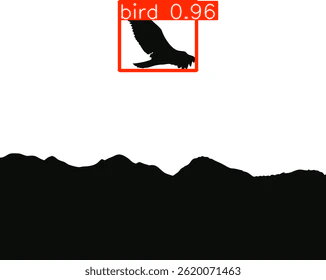

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# Load model
model = YOLO("runs/detect/bird_detector2/weights/best.pt")

# Run inference
results = model.predict(source="flying-eagle-over-mountains-silhouette-260nw-2620071463.webp", conf=0.8, save=False)

# Display result in Colab
for r in results:
    img_with_boxes = r.plot()
    img_bgr = cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)  # Use this instead of cv2.imshow()



image 1/1 /content/bird.webp: 544x640 1 bird, 225.3ms
Speed: 8.1ms preprocess, 225.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


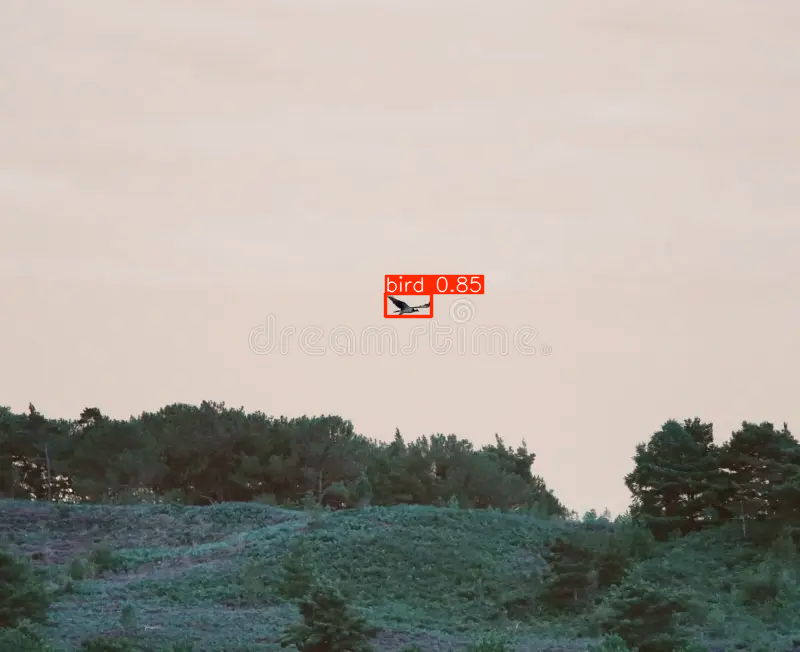

In [ ]:
# Run inference
results = model.predict(source="bird.webp", conf=0.8, save=False)

# Display result in Colab
for r in results:
    img_with_boxes = r.plot()
    img_bgr = cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)  # Use this instead of cv2.imshow()